MNIST 데이터


*   0부터 9까지의 이미지로 구성된 손글씨 데이터셋
*   60,000개의 훈련데이터 및 레이블, 총 10,000개의 테스트 데이터와 레이블
*   레이블은 0~9 총 10개
*   MNIST 문제: 손글씨로 적힌 숫자 이미지가 들어오면, 그 이미지가 무슨 숫자인지 맞추는 문제
*   28px X 28px 이미지로 구성 => 각 이미지를 784의 원소를 가진 벡터로 만들어 줌 => 총 784개의 특성을 가진 샘플이 됨.

In [ ]:
from google.colab import drive  # Google Colab에서 드라이브를 마운트(하드디스크 같은 물리적인 장치를 디렉토리에 연결시켜 주는 것)하기 위해 필요한 모듈
drive.mount('/content/drive')  # '/content/drive' 경로에 Google 드라이브를 마운트

In [ ]:
import torch #PyTorch의 핵심 패키지로, 다차원 텐서(다차원 배열 통칭)를 지원하는 머신 러닝 프레임워크
import torchvision.datasets as dsets # 이미지 데이터셋을 다루는 데 사용되는 PyTorch 패키지
import torchvision.transforms as transforms # 이미지 데이터 전처리를 위한 도구를 제공
from torch.utils.data import DataLoader # PyTorch의 데이터셋을 미니 배치로 나누어 반복할 수 있는 데이터 로더. 머신 러닝 모델을 학습할 때 사용
import torch.nn as nn # PyTorch의 신경망 모델을 구축하는 데 사용되는 패키지
import matplotlib.pyplot as plt # 데이터 시각화를 위한 Python 라이브러리
import random # 난수 생성 및 관련된 기능을 제공하는 Python 표준 라이브러리

구글의 Colab에서 '런타임 > 런타임 유형 변경 > 하드웨어 가속기 > GPU'를 선택하면 USE_CUDA의 값이 True가 되면서 '다음 기기로 학습합니다: cuda'라는 출력이 나옵니다. 즉, GPU로 연산하겠다는 의미입니다. 반면에 '하드웨어 가속기 > None'을 선택하면 USE_CUDA의 값이 False가 되면서 '다음 기기로 학습합니다: cpu'라는 출력이 나옵니다. 즉, CPU로 연산하겠다는 의미입니다.

In [ ]:
USE_CUDA = torch.cuda.is_available() # GPU를 사용할 수 있으면 True, 아니면 False를 리턴
device = torch.device("cuda" if USE_CUDA else "cpu") # GPU를 사용할 수 있으면 사용하고 아니면 CPU 사용
print("다음 기기로 학습합니다:",device)

다음 기기로 학습합니다: cuda


In [ ]:
# for reproducibility(재현성)
random.seed(777) # random의 시드를 777로 설정. 이렇게 하면 코드가 실행될 때마다 동일한 순서로 난수가 생성된다.
torch.manual_seed(777) # PyTorch의 난수 발생기에 대한 시드를 설정
if device == 'cuda': # CUDA 연산을 사용하는 경우
  torch.cuda.manual_seed_all(777) # GPU의 난수 발생기에 대한 시드를 설정. 이렇게 하면 GPU를 사용할 때도 동일한 결과를 얻을 수 있음.

In [ ]:
#hyperparameters
training_epochs = 15
batch_size = 100

torchvision.datasets.dsets.MNIST를 사용하여 MNIST 데이터셋을 불러올 수 있음

In [ ]:
# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/', # MNIST 데이터를 다운로드 받을 경로
                          train=True, # 훈련 데이터를 리턴받음
                          transform=transforms.ToTensor(), # 현재 데이터를 파이토치 텐서로 변환해 줌.
                          download=True) # 해당 경로에 MNIST 데이터가 없다면 다운로드 받겠다는 의미

mnist_test = dsets.MNIST(root='MNIST_data/', # MNIST 데이터를 다운로드 받을 경로
                         train=False, # 테스트 데이터를 리턴받음
                         transform=transforms.ToTensor(), # 현재 데이터를 파이토치 텐서로 변환해 줌.
                         download=True) # 해당 경로에 MNIST 데이터가 없다면 다운로드 받겠다는 의미

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:00<00:00, 16729005.71it/s]


Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 423233.21it/s]


Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 1648877/1648877 [00:00<00:00, 4489640.36it/s]


Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7029715.41it/s]

Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



drop_last를 하는 이유를 이해하기 위해서 1,000개의 데이터가 있다고 했을 때, 배치 크기가 128이라고 해봅시다. 1,000을 128로 나누면 총 7개가 나오고 나머지로 104개가 남습니다. 이때 104개를 마지막 배치로 한다고 하였을 때 128개를 충족하지 못하였으므로 104개를 그냥 버릴 수도 있습니다. 이때 마지막 배치를 버리려면 drop_last=True를 해주면 됩니다. 이는 다른 미니 배치보다 개수가 적은 마지막 배치를 경사 하강법에 사용하여 마지막 배치가 상대적으로 과대 평가되는 현상을 막아줍니다.

In [ ]:
# dataset loader
data_loader = DataLoader(dataset=mnist_train, # 로드할 대상
                                          batch_size=batch_size, # 배치 크기는 100
                                          shuffle=True, # 매 에포크마다 미니 배치를 셔플할 것인지의 여부
                                          drop_last=True) # 마지막 배치를 버릴 것인지

to() 함수는 모델의 매개변수를 지정한 장치의 메모리로 보냅니다. CPU를 사용할 경우에는 필요가 없지만, GPU를 사용하려면 to('cuda')를 해 줄 필요가 있습니다. 아무것도 지정하지 않은 경우에는 CPU 연산이라고 보면 됩니다.
bias의 기본값은 True입니다.

In [ ]:
# MNIST data image of shape 28 * 28 = 784
linear = nn.Linear(784, 10, bias=True).to(device) # input_dim = 784, output_dim = 10

앞서 소프트맥스 회귀를 배울 때는 torch.nn.functional.cross_entropy()를 사용하였으나 여기서는 torch.nn.CrossEntropyLoss()을 사용하고 있습니다. 둘 다 파이토치에서 제공하는 크로스 엔트로피 함수로 둘 다 소프트맥스 함수를 포함하고 있습니다.

In [ ]:
# 비용 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss().to(device) # 내부적으로 소프트맥스 함수를 포함하고 있음.
optimizer = torch.optim.SGD(linear.parameters(), lr=0.1) # SGD(Stochastic Gradient Descent)를 사용하여 모델의 학습 가능한 파라미터를 업데이트

In [ ]:
for epoch in range(training_epochs):  # training_epochs: 전체 데이터셋을 몇 번 반복할 것인지를 결정하는 에포크 수
    avg_cost = 0  # 각 에포크마다 손실의 평균을 저장할 변수를 초기화
    total_batch = len(data_loader) # 전체 배치의 개수

    for X, Y in data_loader:  # 데이터로더를 통해 미니 배치(전체 데이터셋을 작은 일부 그룹으로 나누는 것) 단위로 데이터를 가져옴
        # 입력 데이터를 2차원에서 1차원으로 평탄화한다. MNIST 데이터의 경우 28x28 크기이므로 784로 변환된다.
        X = X.view(-1, 28 * 28).to(device)
        # 레이블을 장치에 올림. (CPU나 GPU 같은 장치로 이동시키는 것)
        Y = Y.to(device)

        optimizer.zero_grad()  # 기울기를 초기화합니다.
        hypothesis = linear(X)  # 모델에 입력을 넣고 예측값을 계산합니다.
        cost = criterion(hypothesis, Y)  # 비용 함수를 사용하여 손실을 계산합니다.
        cost.backward()  # 역전파를 통해 기울기를 계산합니다.
        optimizer.step()  # 옵티마이저를 사용하여 모델 파라미터를 업데이트합니다.

        avg_cost += cost / total_batch  # 배치 손실을 전체 배치 개수로 나눠 평균 손실을 계산합니다.

    # 각 에포크가 끝날 때마다 현재 에포크의 번호와 평균 손실을 출력합니다.
    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

# 학습이 완료되었음을 출력합니다.
print('Learning finished')


Epoch: 0001 cost = 0.535150588
Epoch: 0002 cost = 0.359577715
Epoch: 0003 cost = 0.331264287
Epoch: 0004 cost = 0.316404670
Epoch: 0005 cost = 0.307106972
Epoch: 0006 cost = 0.300456554
Epoch: 0007 cost = 0.294933438
Epoch: 0008 cost = 0.290956199
Epoch: 0009 cost = 0.287074119
Epoch: 0010 cost = 0.284515619
Epoch: 0011 cost = 0.281914055
Epoch: 0012 cost = 0.279526889
Epoch: 0013 cost = 0.277636588
Epoch: 0014 cost = 0.275874794
Epoch: 0015 cost = 0.274422765
Learning finished




```
X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
```


*   .view(-1, 28 * 28): 가져온 이미지를 평탄화(flatten)합니다. MNIST 이미지는 각각 28x28 픽셀의 2차원 배열로 되어 있지만, 이를 하나의 벡터로 평탄화하여 모델에 입력으로 사용할 수 있도록 합니다. -1은 해당 차원의 크기를 자동으로 결정하라는 의미입니다.
*   .float(): 이미지를 부동소수점(float) 타입으로 변환합니다. 보통 이미지는 정수 형태로 저장되어 있지만, 신경망 모델에 입력하기 위해서는 부동소수점 형태로 변환해야 합니다.
*    .to(device): 데이터를 지정된 장치로 이동



Accuracy: 0.8883000016212463
Label:  8
Prediction:  3


/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


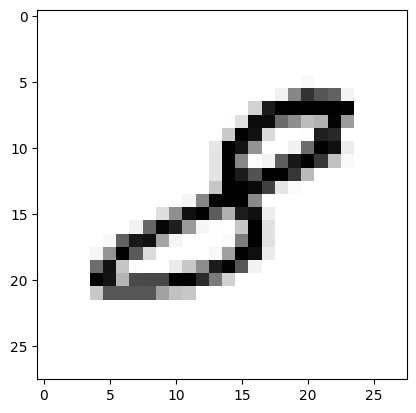

In [ ]:
# 테스트 데이터를 사용하여 모델을 평가합니다.
with torch.no_grad():  # torch.no_grad()를 호출하면 gradient 계산을 수행하지 않습니다.
    # 테스트 데이터를 준비합니다. 데이터를 평탄화하고 장치로 이동합니다.
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    # 모델을 사용하여 예측을 수행합니다.
    prediction = linear(X_test)
    # 예측한 클래스 중 가장 큰 값을 선택하여 정확도를 계산합니다.
    correct_prediction = torch.argmax(prediction, 1) == Y_test # 모델이 테스트 데이터셋을 통해 예측한 클래스에 대한 확률 분포
    accuracy = correct_prediction.float().mean()  # 정확한 예측의 비율을 계산합니다.
    print('Accuracy:', accuracy.item())

    # MNIST 테스트 데이터에서 무작위로 하나를 선택하여 해당 이미지의 예측을 출력합니다.
    r = random.randint(0, len(mnist_test) - 1)  # 무작위로 인덱스를 선택합니다.
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())  # 선택된 이미지의 실제 레이블을 출력합니다.
    single_prediction = linear(X_single_data)  # 모델을 사용하여 예측을 수행합니다.
    print('Prediction: ', torch.argmax(single_prediction, 1).item())  # 예측된 클래스를 출력합니다.

    # 선택된 이미지를 시각화하여 출력합니다.
    plt.imshow(mnist_test.test_data[r:r + 1].view(28, 28), cmap='Greys', interpolation='nearest')
    plt.show()
